# Linear Regression model 

# Team Project

## Sigma : 조현윤, 이상협, 정하연

## object : NewYork City Taxi Trip Duration
### - the duration time for each id

## evaluation metric : Root Mean Squared Logarithmic Error

#### training data set : 701778rows, 11columns
- dropoff_datetime, trip_duration 정보를 포함하고 있음
- pickup_datetime, pickup_longitude, pickup_latitude 정보
- dropoff_datetime, dropoff_longitude, pickup_latitude  정보
- pickup_longitude, pickup_latitude와 dropoff_longitude, pickup_latitude 를 이용하여 승차지점과 하차지점 사이의 거리를 구할 수 있음. 
- test data set에서 dropoff_datetime 정보가 없는 것으로 보아 회귀분석 모형을 만들때, dropoff_datetime정보는 생략을 할 필요성이 있을 것 같음
- trip duration은 second(초)로 되어 있음
- 목적은 trip_duration 정보를 예측할 수 있는 회귀분석을 만드는 것

#### test data set : 346797rows, 9columns


### Load Python Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from datetime import date
from math import atan2, radians, sin, cos, sqrt
import seaborn as sns
%matplotlib inline

### Definition of Function

In [2]:
# Calculate Distance using longitude & latitude between two points.
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

### Load Training Data

In [269]:
train = pd.read_csv('./data/train.csv')
print ("Training data has {} rows and {} columns".format(train.shape[0],train.shape[1]))
print ("data : {}".format(train.shape[0]))
print ("Feature : {}".format(train.shape[1]))

Training data has 701778 rows and 11 columns
data : 701778
Feature : 11


### Check Training Data

In [270]:
train.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
701773,id3888279,1,1/1/16 0:01,1/1/16 0:05,1,-73.982292,40.751331,-73.991341,40.750340,N,280
701774,id1210365,2,1/1/16 0:01,1/1/16 0:07,5,-73.965279,40.801041,-73.947479,40.815170,N,408
701775,id0924227,1,1/1/16 0:01,1/1/16 0:13,1,-73.970108,40.759800,-73.989357,40.742989,N,736
701776,id0190469,2,1/1/16 0:00,1/1/16 0:14,5,-73.981743,40.719158,-73.938828,40.829182,N,849
701777,id1665586,1,1/1/16 0:00,1/1/16 0:22,1,-73.985085,40.747166,-73.958038,40.717491,N,1294


In [271]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701778 entries, 0 to 701777
Data columns (total 11 columns):
id                    701778 non-null object
vendor_id             701778 non-null int64
pickup_datetime       701778 non-null object
dropoff_datetime      701778 non-null object
passenger_count       701778 non-null int64
pickup_longitude      701778 non-null float64
pickup_latitude       701778 non-null float64
dropoff_longitude     701778 non-null float64
dropoff_latitude      701778 non-null float64
store_and_fwd_flag    701778 non-null object
trip_duration         701778 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 58.9+ MB


In [272]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,701778.000000,7.017780e+05
mean,1.536037,1.666577,-73.973665,40.750969,-73.973583,40.751836,9.387318e+02
std,0.498700,1.319466,0.043910,0.033139,0.044214,0.037572,6.772504e+03
min,1.000000,0.000000,-78.547401,34.359695,-79.817978,32.181141,1.000000e+00
25%,1.000000,1.000000,-73.991829,40.737400,-73.991325,40.735959,3.900000e+02
50%,2.000000,1.000000,-73.981789,40.754150,-73.979828,40.754478,6.480000e+02
75%,2.000000,2.000000,-73.967567,40.768246,-73.963249,40.769691,1.047000e+03
max,2.000000,8.000000,-61.335529,43.486885,-61.335529,43.674000,3.526282e+06


### Check whether missing value exists

In [273]:
print ('There are not Missing Values') if np.any(train != np.NaN) else print ('There are Missing Values')

There are not Missing Values


### Check Whether id is Unique

In [274]:
print('Id is unique. Count : {}'.format(train.shape[0])) if train.id.nunique() == train.shape[0] else print('oops')
train.isnull().sum(axis=0).reset_index()

Id is unique. Count : 701778


,index,0
0,id,0
1,vendor_id,0
2,pickup_datetime,0
3,dropoff_datetime,0
4,passenger_count,0
5,pickup_longitude,0
6,pickup_latitude,0
7,dropoff_longitude,0
8,dropoff_latitude,0
9,store_and_fwd_flag,0


### Confirm Features

#### vendor_id

In [275]:
countVendorID = train['vendor_id'].value_counts().sort_index()
print (countVendorID)

1    325599
2    376179
Name: vendor_id, dtype: int64


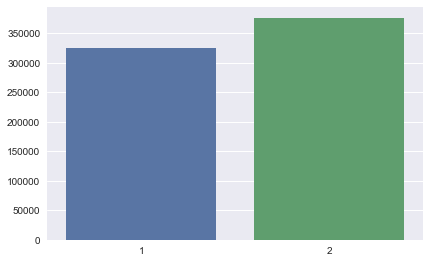

In [276]:
sns.barplot(countVendorID.index, countVendorID.values)

* vendor_id
 * 1, 2의 값만을 가짐
  * **category value**

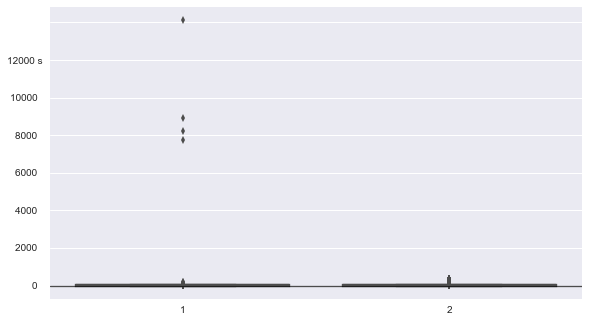

,count,mean,std,min,25%,50%,75%,max
vendor_id,,,,,,,,
1,325599.0,837.073081,8845.435788,1.0,388.0,644.0,1041.0,3526282.0
2,376179.0,1026.721797,4222.366691,1.0,392.0,652.0,1052.0,86369.0


In [277]:
# Create boxplot
plt.figure(figsize=(8.5,5))
vendor_graph = sns.boxplot(x = 'vendor_id', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)

# Customize tick labels of the y-axis
vendor_graph.set_yticklabels(labels = [-10, '0  ', '2000  ', '4000  ', '6000  ', '8000  ', '10000  ','12000 s'])

# Bolding horizontal line at y = 0
vendor_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
vendor_graph.xaxis.label.set_visible(False)
vendor_graph.yaxis.label.set_visible(False)

plt.show()

# Statistical summary
train.groupby('vendor_id')['trip_duration'].describe()

#### Passenger Count

In [278]:
countPassenger_Count = train['passenger_count'].value_counts().sort_index()
print (countPassenger_Count)

0        31
1    497800
2    100422
3     28321
4     13568
5     38131
6     23503
7         1
8         1
Name: passenger_count, dtype: int64


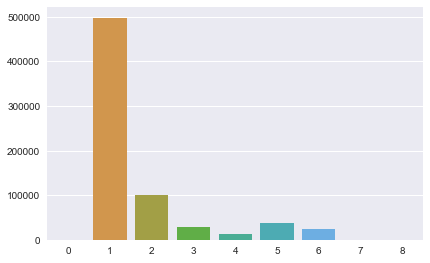

In [279]:
sns.barplot(countPassenger_Count.index, countPassenger_Count.values)

* passenger Count
 * 0, 1, 2, 3, 4, 5, 6, 7, 8의 값을 가진다
 * 해당 row의 정보에서 택시에 탑승한 승객의 수를 이야기한다. 
 * Category value?

In [1]:
# Settings
import matplotlib
matplotlib.style.use('fivethirtyeight')

# Create boxplot
plt.figure(figsize=(14,8))
passenger_graph = sns.boxplot(x = 'passenger_count', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)

# Customize tick size
passenger_graph.tick_params(axis = 'both', which = 'major', labelsize = 12)

# Customize tick labels of the y-axis
passenger_graph.set_yticklabels(labels = [-10, '0  ', '2000  ', '4000  ', '6000  ', '8000  ', '10000  ','12000 s'])

# Bolding horizontal line at y = 0
passenger_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Add an extra vertical line by tweaking the range of the x-axis
#month_graph.set_xlim(left = -1, right = 6)

# Remove the label of the x-axis
passenger_graph.xaxis.label.set_visible(False)
passenger_graph.yaxis.label.set_visible(False)
plt.show()

# Statistical summary
train.groupby('passenger_count')['trip_duration'].describe().transpose()

AttributeError: module 'matplotlib' has no attribute 'style'

#### location information
* longitude (경도)
 * 적도를 기준으로 북쪽 또는 남쪽으로 얼마나 떨어져 있는지 나타내는 위치
* latitude (위도)
 * 적도를 기준으로 북쪽 또는 남쪽으로 얼마나 떨어져 있는지 나타내는 위치

#### pickup

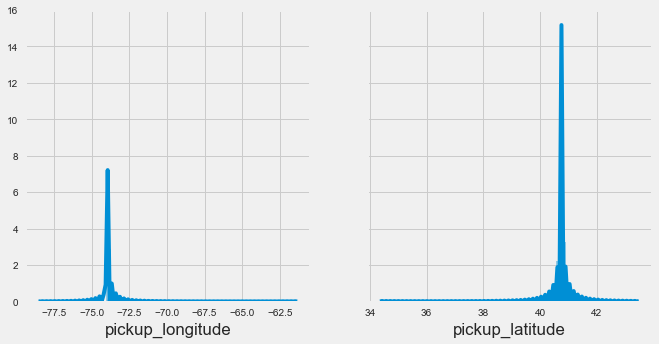

In [281]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey =True, figsize=(10,5))
ax1.set_ylim(0,16)
ax2.set_ylim(0,16)
sns.distplot(train['pickup_longitude'], ax=ax1)
sns.distplot(train['pickup_latitude'], ax=ax2)

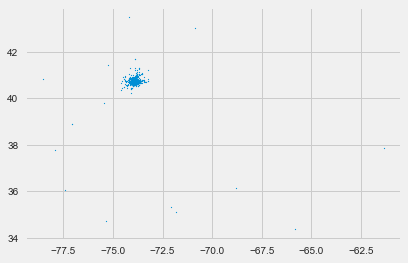

In [282]:
plt.scatter(train['pickup_longitude'],train['pickup_latitude'], s=0.5, alpha=1)

#### pickup 지점의 위치

* 경향
 * longitute (경도) : -75 ~ -72
 * latitude (위도) : 40 ~ 42
 - 집중되어 있는 것을 확인할 수 있음
* 범위를 조절하면서 집중되어 있는 위치에 대하여 그래프

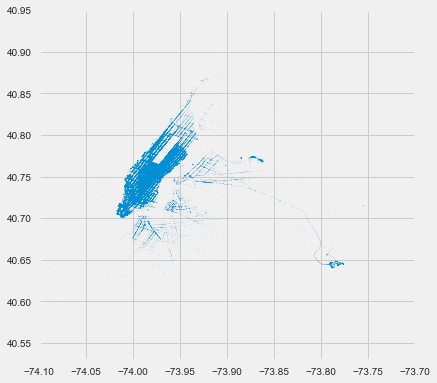

In [283]:
plt.figure(figsize=(6,6))
plt.ylim(40.53, 40.95)
plt.xlim(-74.1,-73.70)
plt.plot(train['pickup_longitude'],train['pickup_latitude'],'.',  alpha=0.4, markersize = 0.4)

#### dropoff

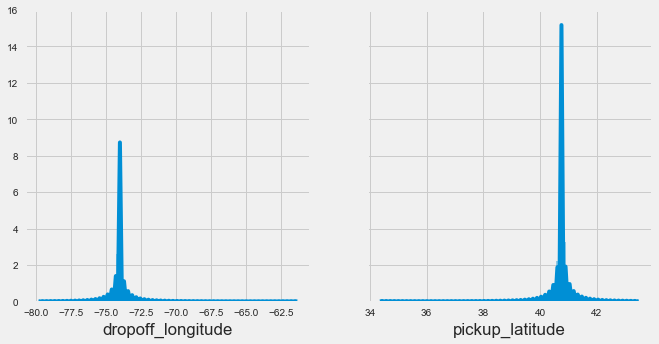

In [284]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey =True, figsize=(10,5))
ax1.set_ylim(0,16)
ax2.set_ylim(0,16)
sns.distplot(train['dropoff_longitude'], ax=ax1)
sns.distplot(train['pickup_latitude'], ax=ax2)

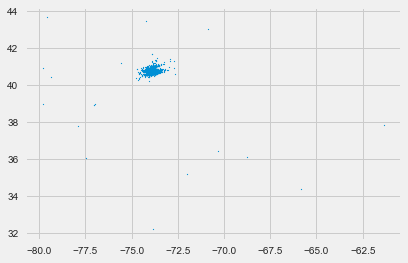

In [285]:
plt.scatter(train['dropoff_longitude'],train['dropoff_latitude'], s=0.5, alpha=1)

* 경향
 * longitute (경도) : -75 ~ -72
 * latitude (위도) : 40 ~ 42
 - 집중되어 있는 것을 확인할 수 있음
* 범위를 조절하면서 집중되어 있는 위치에 대하여 그래프

#### dropoff 지점의 위치

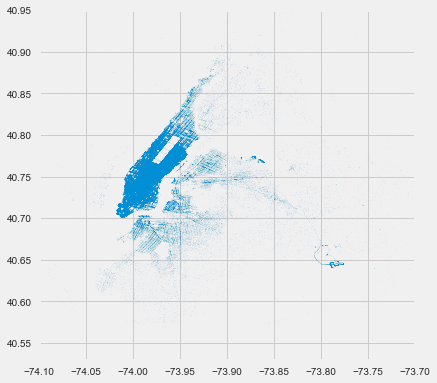

In [286]:
plt.figure(figsize=(6,6))
plt.ylim(40.53, 40.95)
plt.xlim(-74.1,-73.70)
plt.plot(train['dropoff_longitude'],train['dropoff_latitude'],'.', alpha=0.4, markersize = 0.4)

Text(0.5,1,'dropoff')

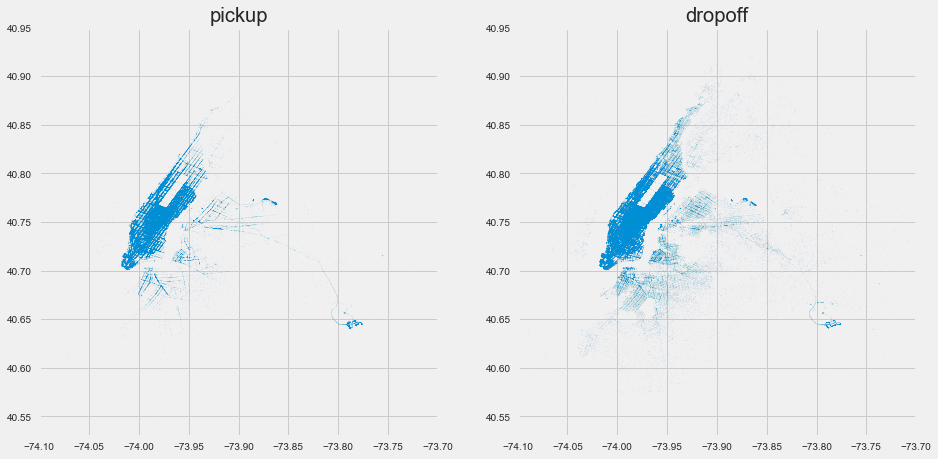

In [288]:
fig, ax = plt.subplots(ncols=2, figsize=(14,7))
ax[0].set_ylim(40.53, 40.95)
ax[0].set_xlim(-74.1,-73.70)
ax[0].plot(train['pickup_longitude'],train['pickup_latitude'],'.',  alpha=0.4, markersize = 0.4)
ax[0].set_title('pickup')
ax[1].set_ylim(40.53, 40.95)
ax[1].set_xlim(-74.1,-73.70)
ax[1].plot(train['dropoff_longitude'],train['dropoff_latitude'],'.', alpha=0.4, markersize = 0.4)
ax[1].set_title('dropoff')

[구글맵:뉴욕](https://www.google.co.kr/maps/place/%EB%AF%B8%EA%B5%AD+%EB%89%B4%EC%9A%95/@40.7766932,-74.2068077,10.25z/data=!4m5!3m4!1s0x89c24fa5d33f083b:0xc80b8f06e177fe62!8m2!3d40.7127753!4d-74.0059728)

* 구글맵을 통하여 위의 그래프에서 나타난 그림의 특성을 비교해보았을때 뉴욕의 지도와 비슷하다는 것을 파악
 * 맨하탄 지역
   * 40.8, -73.95 부근의 사각형 모형은 뉴욕의 central park
 * 브루클린 
 * 욘 F. 케네디 국제공항

#### store_and_fwd_flag

In [289]:
countStore_and_fwd_flag = train['store_and_fwd_flag'].value_counts().sort_index()
print (countStore_and_fwd_flag)

N    697920
Y      3858
Name: store_and_fwd_flag, dtype: int64


* store_and_fwd_flag
 * Y, N 의 값을 가진다.
  * **Category value **

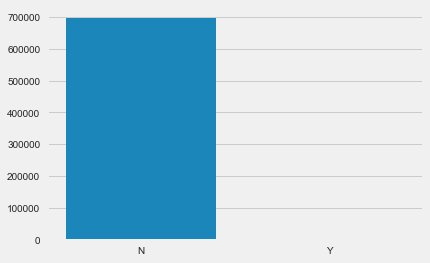

In [290]:
sns.barplot(countStore_and_fwd_flag.index, countStore_and_fwd_flag.values)

In [291]:
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')

* store_and_fwd_flag의 value를 0,1로 변경
 * Y : 1
 * N : 0

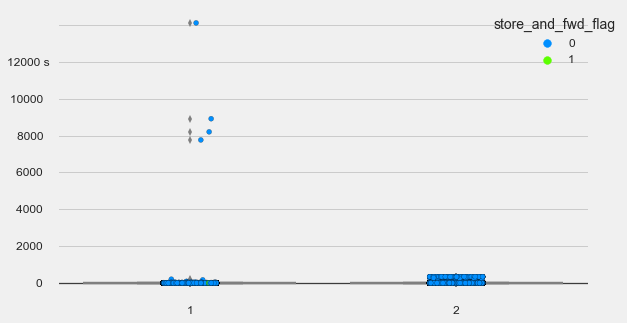

store_and_fwd_flag,0,1
vendor_id,,
1,321741.0,3858.0
2,376179.0,0.0


In [292]:
# Create boxplot
plt.figure(figsize=(8.5,5))
vendor_graph = sns.boxplot(x = 'vendor_id', y = 'trip_duration', data = train, 
                          orient = 'v',color = 'lightgrey', linewidth = 2.3)
plt.setp(vendor_graph.artists, alpha = 0.5)

# Create strip plot
sns.stripplot(data = train, x = 'vendor_id', y = 'trip_duration', jitter = 1, size = 5,
             edgecolor = 'black', linewidth = .2,palette = 'gist_rainbow_r',hue = 'store_and_fwd_flag')

# Customize tick size
vendor_graph.tick_params(axis = 'both', which = 'major', labelsize = 12)

# Customize tick labels of the y-axis
vendor_graph.set_yticklabels(labels = [-10, '0  ', '2000  ', '4000  ', '6000  ', '8000  ', '10000  ','12000 s'])

# Bolding horizontal line at y = 0
vendor_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
vendor_graph.xaxis.label.set_visible(False)
vendor_graph.yaxis.label.set_visible(False)

# Format legend
vendor_graph.legend(title = 'store_and_fwd_flag', bbox_to_anchor = (.80,1),loc = 2, fontsize=12)
plt.show()

# Statistical summary
train.groupby(['vendor_id','store_and_fwd_flag'])['store_and_fwd_flag'].count().unstack().fillna(0)

#### pickup datatime

* pandas의 to_datetime을 이용하여 pickup_datetime의 타입(type)을 변경

In [293]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

* pickup_datetime의 value를 분해하여 추출

In [294]:
train['year']  = train['pickup_datetime'].dt.year

* 년도 정보 추출후 year column에 저장

In [295]:
countYear = train['year'].value_counts().sort_index()
print (countYear)

2016    701778
Name: year, dtype: int64


* 2016년도 자료만 존재함
* valule가 하나만 존재하기 때문에 고려할 필요없는 것으로 여겨짐

In [296]:
train['month'] = train['pickup_datetime'].dt.month

* 월 정보 추출후 month column에 저장

In [297]:
countMonth = train['month'].value_counts().sort_index()
print (countMonth)

1    165104
2    171599
3    184135
4    180940
Name: month, dtype: int64


* 1월부터 4월까지의 데이터가 존재함
* **Category value **

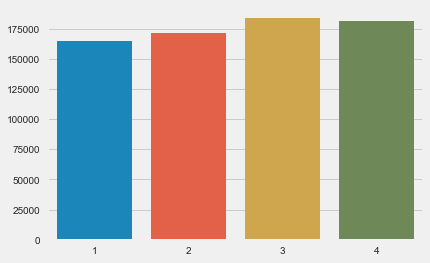

In [298]:
sns.barplot(countMonth.index, countMonth.values)

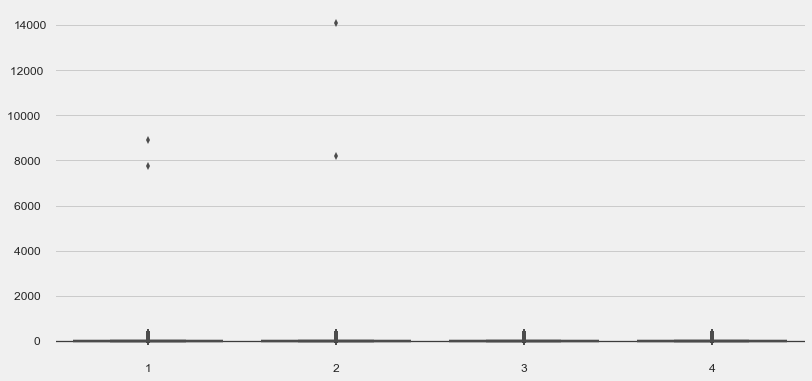

month,1,2,3,4
count,1.651040e+05,1.715990e+05,184135.000000,180940.000000
mean,9.300896e+02,9.298274e+02,935.931729,957.911888
std,7.919125e+03,1.030659e+04,3188.142351,3096.073842
min,1.000000e+00,1.000000e+00,1.000000,1.000000
25%,3.830000e+02,3.840000e+02,393.000000,403.000000
50%,6.290000e+02,6.350000e+02,654.000000,674.000000
75%,1.012000e+03,1.023000e+03,1054.000000,1095.000000
max,2.227612e+06,3.526282e+06,86366.000000,86364.000000


In [299]:
# Create boxplot
plt.figure(figsize=(12,6))
month_graph = sns.boxplot(x = 'month', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)
# Customize tick size
month_graph.tick_params(axis = 'both', which = 'major', labelsize = 12)

# Customize tick labels of the y-axis
month_graph.set_yticklabels(labels = [-10, '0  ', '2000  ', '4000  ', '6000  ', '8000  ', '10000  ','12000 ','14000'])
# Bolding horizontal line at y = 0
month_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)


# Add an extra vertical line by tweaking the range of the x-axis
#month_graph.set_xlim(left = -1, right = 6)

# Remove the label of the x-axis
month_graph.xaxis.label.set_visible(False)
month_graph.yaxis.label.set_visible(False)

plt.show()

# Statistical summary
train.groupby('month')['trip_duration'].describe().transpose()

In [300]:
train['day']   = train['pickup_datetime'].dt.day

* 일 정보 추출후 day column에 저장

In [301]:
countDay = train['day'].value_counts().sort_index()
print (countDay)

1     22225
2     23054
3     22515
4     23191
5     24143
6     23698
7     22806
8     23254
9     24574
10    23582
11    23475
12    24642
13    24318
14    24108
15    23834
16    24810
17    23412
18    23171
19    24326
20    24106
21    22748
22    22820
23    18828
24    20099
25    21562
26    23186
27    22984
28    22821
29    23566
30    18589
31    11331
Name: day, dtype: int64


* 1 ~ 31까지 나타남
* **Category value**

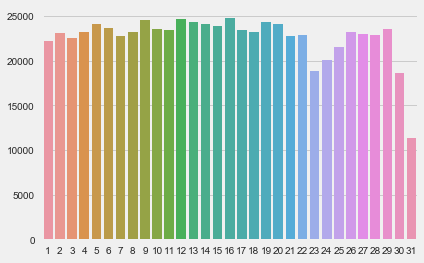

In [302]:
sns.barplot(countDay.index, countDay.values)

In [303]:
train['hr']    = train['pickup_datetime'].dt.hour

* 시 정보 추출후 hr column에 저장

In [304]:
countHour = train['hr'].value_counts().sort_index()
print (countHour)

0     25191
1     18339
2     13439
3     10025
4      7486
5      7080
6     15665
7     26728
8     32183
9     32416
10    31245
11    32523
12    34449
13    34260
14    36006
15    34806
16    31531
17    37340
18    44363
19    43808
20    40960
21    40485
22    38300
23    33150
Name: hr, dtype: int64


* 0 ~ 24 까지의 밸류값을 가짐

In [ ]:
sns.barplot(countHour.index,countHour.values)

In [306]:
train['minute']= train['pickup_datetime'].dt.minute

* 분 정보 추출후 minute column에 저장

In [307]:
countMinute = train['minute'].value_counts().sort_index()
print (countMinute)

0     11474
1     11531
2     11631
3     11554
4     11435
5     11614
6     11746
7     11567
8     11924
9     11686
10    11671
11    11759
12    11736
13    11592
14    11710
15    11502
16    11691
17    11822
18    11659
19    11794
20    11560
21    11915
22    11582
23    11526
24    11440
25    11465
26    11521
27    11572
28    11373
29    11627
30    11620
31    11601
32    11653
33    11674
34    11546
35    11582
36    11625
37    11726
38    11776
39    11635
40    11697
41    11563
42    11939
43    11707
44    11917
45    12068
46    11878
47    11764
48    12370
49    12040
50    12125
51    11804
52    11843
53    11885
54    11908
55    11587
56    11794
57    11834
58    11508
59    11430
Name: minute, dtype: int64


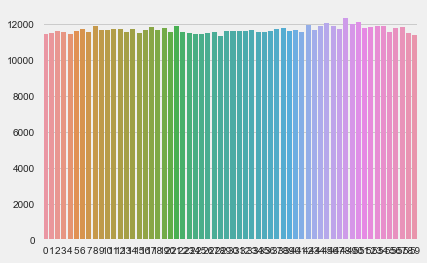

In [308]:
sns.barplot(countMinute.index,countMinute.values)

In [309]:
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek + 1

* 요일 정보 추출후 day_of_week column에 저장
* 1, 2, 3, 4, 5, 6, 7 의 value를 가짐
* 월, 화, 수, 목, 금, 토, 일에 해당

In [310]:
countDayOfWeek = train['day_of_week'].value_counts().sort_index()
print (countDayOfWeek)

1     88552
2     95208
3     99212
4    103534
5    112378
6    110500
7     92394
Name: day_of_week, dtype: int64


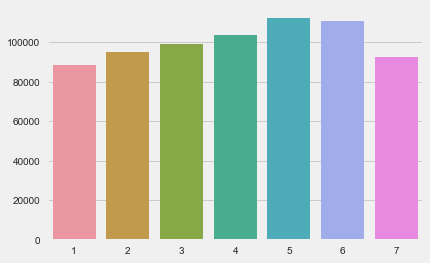

In [311]:
sns.barplot(countDayOfWeek.index,countDayOfWeek.values)

In [312]:
train.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,year,month,day,hr,minute,day_of_week
701773,id3888279,1,2016-01-01 00:01:00,1/1/16 0:05,1,-73.982292,40.751331,-73.991341,40.750340,0,280,2016,1,1,0,1,5
701774,id1210365,2,2016-01-01 00:01:00,1/1/16 0:07,5,-73.965279,40.801041,-73.947479,40.815170,0,408,2016,1,1,0,1,5
701775,id0924227,1,2016-01-01 00:01:00,1/1/16 0:13,1,-73.970108,40.759800,-73.989357,40.742989,0,736,2016,1,1,0,1,5
701776,id0190469,2,2016-01-01 00:00:00,1/1/16 0:14,5,-73.981743,40.719158,-73.938828,40.829182,0,849,2016,1,1,0,0,5
701777,id1665586,1,2016-01-01 00:00:00,1/1/16 0:22,1,-73.985085,40.747166,-73.958038,40.717491,0,1294,2016,1,1,0,0,5


In [313]:
train['pickup_date'] = train['pickup_datetime'].dt.date # Extract date
train['pickup_time'] = train['pickup_datetime'].dt.time # Extract time

* pickup_datetime column으로부터 pickup 날짜와 pickup 시간을 추출함

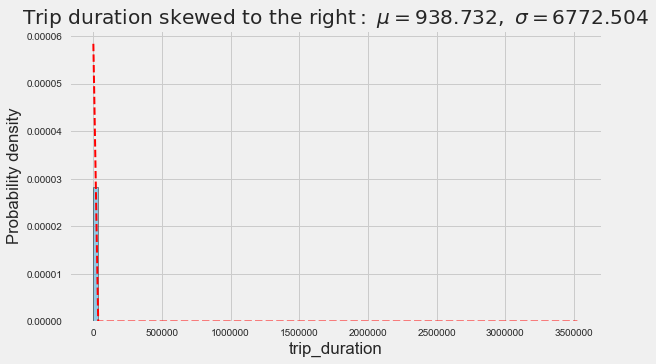

,count,mean,std,min,25%,50%,75%,max
trip_duration,701778.0,938.731817,6772.504153,1.0,390.0,648.0,1047.0,3526282.0


In [314]:
import matplotlib.mlab as mlab
# Mean distribution
mu = train['trip_duration'].mean()

# Std distribution
sigma = train['trip_duration'].std()
num_bins = 100

# Histogram 
fig = plt.figure(figsize=(8.5, 5))
n, bins, patches = plt.hist(train['trip_duration'], num_bins, normed=1,
                           edgecolor = 'black', lw = 1, alpha = .40)
# Normal Distribution
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('trip_duration')
plt.ylabel('Probability density')

# Adding a title
plt.title(r'$\mathrm{Trip\ duration\ skewed \ to \ the \ right:}\ \mu=%.3f,\ \sigma=%.3f$'%(mu,sigma))
plt.grid(True)
#fig.tight_layout()
plt.show()

# Statistical summary
train.describe()[['trip_duration']].transpose()

In [315]:
train['trip_duration'].quantile(0.999)

84977.23000000115

* trip_duration 값을 quantile 99.9%까지의 값을 계산
 * 84977.23000000115

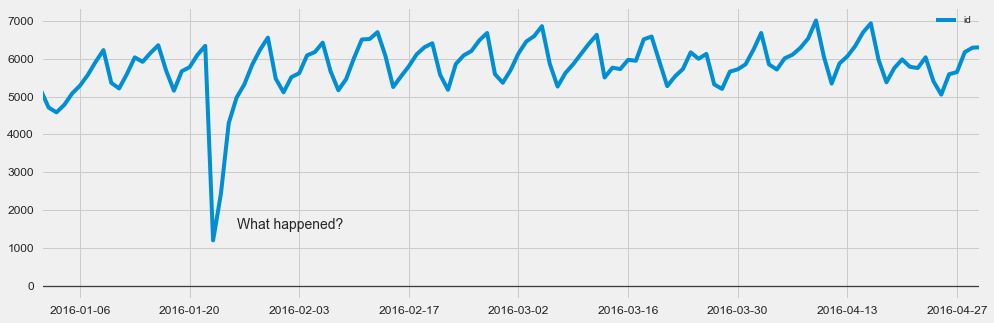

In [316]:
# Summarize total trips by day
pickups_by_day = train.groupby('pickup_date').count()['id']

# Create graph
pickups_graph = pickups_by_day.plot(x = 'pickup_date', y = 'id', figsize = (15,5),legend = True)

# Customize tick size
pickups_graph.tick_params(axis = 'both', which = 'major', labelsize = 12)

# Bold horizontal line at y = 0
pickups_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

# Customize tick labels of the y-axis
#pickups_graph.set_yticklabels(labels = [-10, '2000   ', '4000   ', '6000   ', '8000   ', '10000   '])

# Add an extra vertical line by tweaking the range of the x-axis
pickups_graph.set_xlim(left = '2016-01-01', right = '2016-04-30')

# Remove the label of the x-axis
pickups_graph.xaxis.label.set_visible(False)
pickups_graph.text(x = '2016-01-26', y = 1500, s = 'What happened?',weight = 0, rotation = 0, size = 14)
plt.show()

* 2016년 01월 01일부터 2016년 04월 30일까지의 일별 데이터량
* 유독 낮은 데이터양을 보이는 날이 나타남
 * 2016년 01월 23일 : 1195

In [317]:
train.groupby('pickup_date').count()['id'].sort_values(ascending = True)[[0]]

pickup_date
2016-01-23    1195
Name: id, dtype: int64

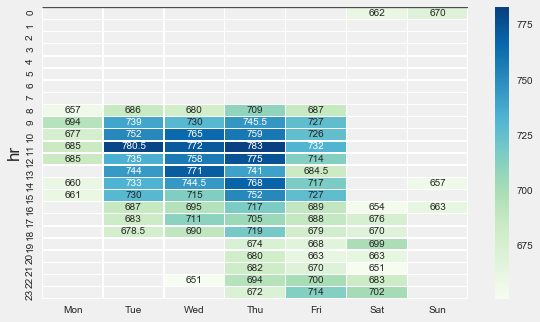

In [318]:
# Trips by Hour and Day of Week
trip_duration_median = train['trip_duration'].median()
plt.figure(figsize=(8.5,5))
pickup_hourday = train.groupby(['hr','day_of_week'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_hourday[pickup_hourday>trip_duration_median],
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
# plt.ylabel('pickup_hour (military time)')
# plt.xlabel('pickup_weekday (Mon - Sun)')
# plt.title('Median Trip Duration by Pickup Hour and Day of Week')
plt.show()

In [319]:
trip_duration_median

648.0

* 요일별로 각 시간대별로 trip_duration의 중앙값인 648.0보다 높게 나타난 데이터의 수를 계산
 * 월~금까지 08:00 ~ 18:00까지 높게 나타나는 경향을 보임
 * 목,금,토 18:00 ~ 자정까지 증가
 * 토요일, 일요일 의 00:00 ~ 01:00까지 증가
 * 일요일 오후에 증가

#### Distance Column 추가
* pickup의 longitude, latitude와 dropoff의 longitude, latitude를 사용하여 두 지점사이의 거리를 구할 수 있다. 


In [320]:
train['distance'] = train.apply(lambda x:haversine_array(x.pickup_latitude, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude), axis =1 )

* distance
 * the direct distance of two GPS location, taking into account that the earth is round.

In [321]:
train['dummy_manhattan_dist'] = train.apply(lambda x:dummy_manhattan_distance(x.pickup_latitude, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude), axis =1 )

* Manhattan distance 
 * the usual L1 distance, here the haversine distance is used to calculate each coordinate of distance.

In [322]:
train['bearing'] = train.apply(lambda x:bearing_array(x.pickup_latitude, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude), axis =1 )

    * Bearing
      * The direction of the trip. Using radian as unit.

In [323]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701778 entries, 0 to 701777
Data columns (total 22 columns):
id                      701778 non-null object
vendor_id               701778 non-null int64
pickup_datetime         701778 non-null datetime64[ns]
dropoff_datetime        701778 non-null object
passenger_count         701778 non-null int64
pickup_longitude        701778 non-null float64
pickup_latitude         701778 non-null float64
dropoff_longitude       701778 non-null float64
dropoff_latitude        701778 non-null float64
store_and_fwd_flag      701778 non-null int32
trip_duration           701778 non-null int64
year                    701778 non-null int64
month                   701778 non-null int64
day                     701778 non-null int64
hr                      701778 non-null int64
minute                  701778 non-null int64
day_of_week             701778 non-null int64
pickup_date             701778 non-null object
pickup_time             701778 non-null o

### trip_duration quantile 99.9%까지의 값만을 가지고 이후 분석진행

In [324]:
train = train[:][train['trip_duration'] < 84977.23000000115]
#train = train[:][train['trip_duration'] < 15000]

List the numerical features in decending order by their correlation with trip_duration:

distance: 0.287431438993909
dummy_manhattan_dist: 0.28094216015399825
pickup_longitude: 0.12965152552832324
pickup_latitude: -0.08142303987240093
dropoff_longitude: 0.07262078408170425
dropoff_latitude: -0.06087613427330857
month: 0.01639249991440972
passenger_count: 0.01268851263705104
day_of_week: -0.011580991271140775
day: 0.009215911871362222
hr: 0.006125526562379832
minute: -0.00497691066634544
bearing: 0.0015714847203117065


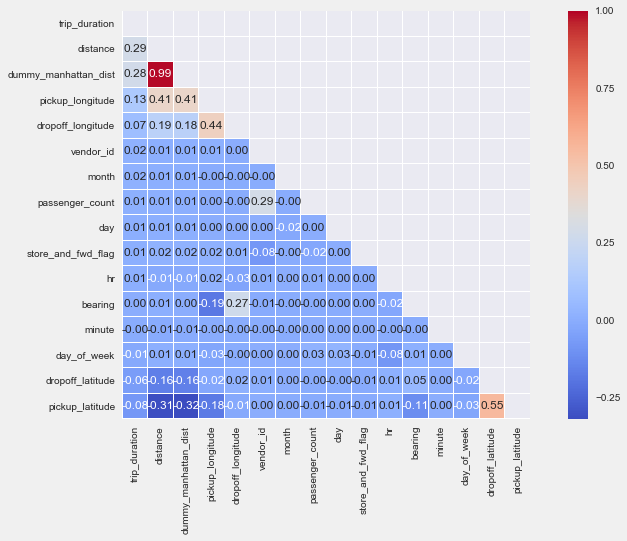

In [325]:
# Correlations to trip_duration
corr = train.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
cor_dict = corr['trip_duration'].to_dict()
del cor_dict['trip_duration']
#del cor_dict['vendor_id']
del cor_dict['year']
print("List the numerical features in decending order by their correlation with trip_duration:\n")
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: {1}".format(*ele))
    
# Correlation matrix heatmap
corrmat = train.corr()
plt.figure(figsize=(12, 7))

# Number of variables for heatmap
k = len(corrmat)
cols = corrmat.nlargest(k, 'trip_duration')['trip_duration'].index
cm = np.corrcoef(train[cols].values.T)

# Generate mask for upper triangle
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1)
sns.heatmap(cm, mask=mask, cbar=True, annot=True, square=True,\
                 fmt='.2f',annot_kws={'size': 12}, yticklabels=cols.values,\
                 xticklabels=cols.values, cmap = 'coolwarm',lw = .1)
plt.show() 

In [326]:
train.keys()

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'year', 'month', 'day', 'hr', 'minute', 'day_of_week',
       'pickup_date', 'pickup_time', 'distance', 'dummy_manhattan_dist',
       'bearing'],
      dtype='object')

In [327]:
xValue = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'month', 'day', 'hr', 'day_of_week',
        'distance', 'dummy_manhattan_dist','bearing']
yValue = train['trip_duration']

In [328]:
import statsmodels.api as sm

* prediction Value
 * trip_duration
* feature Values
 * id
 * vendor_id
 * passenger_count
 * pickup_datetime 
 * 위치에 대한 정보
   * pickup_longitude
   * pickup_latitude
   * dropoff_longitude
   * dropoff_latitude
 * store_and_fwd_flag
 * year 
 * month
 * day 
 * hr 
 * minute
 * day_of_week 
 * distance
 * dummy_manhattan_dist
 * bearing


In [329]:
#model1 = sm.OLS.from_formula("trip_duration ~ C(vendor_id) + passenger_count + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + C(store_and_fwd_flag) + month +  hr +  day_of_week + distance + dummy_manhattan_dist + bearing", train)
model1 = sm.OLS.from_formula("trip_duration ~ passenger_count + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude +  C(hr) +  C(day_of_week) + distance + dummy_manhattan_dist + bearing + 0", train)
resultForLR1 = model1.fit()
print (resultForLR1.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     1871.
Date:                Mon, 16 Oct 2017   Prob (F-statistic):               0.00
Time:                        11:39:26   Log-Likelihood:            -6.1340e+06
No. Observations:              701076   AIC:                         1.227e+07
Df Residuals:                  701038   BIC:                         1.227e+07
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
C(hr)[0]              7.857e+04 

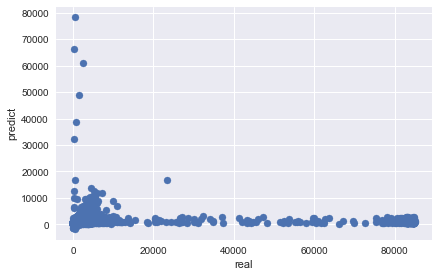

In [330]:
c1= 'passenger_count+pickup_longitude+pickup_latitude+dropoff_longitude+dropoff_latitude+hr+day_of_week+distance+dummy_manhattan_dist+bearing'.split('+')
m1Predict = resultForLR1.predict(train[c1])
plt.scatter(train['trip_duration'], m1Predict)
plt.xlabel(u'real')
plt.ylabel(u'predict')
plt.show()

In [362]:
sm.stats.anova_lm(resultForLR1, typ=2)

,sum_sq,df,F,PR(>F)
C(hr),6.427961e+09,24.0,115.004289,0.000000e+00
C(day_of_week),1.536523e+09,6.0,109.961315,3.452307e-139
passenger_count,2.022631e+08,1.0,86.849777,1.174078e-20
pickup_longitude,6.109563e+07,1.0,26.233860,3.025521e-07
pickup_latitude,1.581771e+08,1.0,67.919660,1.705833e-16
dropoff_longitude,3.095952e+08,1.0,132.937133,9.391941e-31
dropoff_latitude,5.728338e+08,1.0,245.969179,2.007553e-55
distance,1.032503e+10,1.0,4433.467190,0.000000e+00
dummy_manhattan_dist,3.944652e+09,1.0,1693.794432,0.000000e+00
bearing,1.693219e+07,1.0,7.270515,7.009736e-03


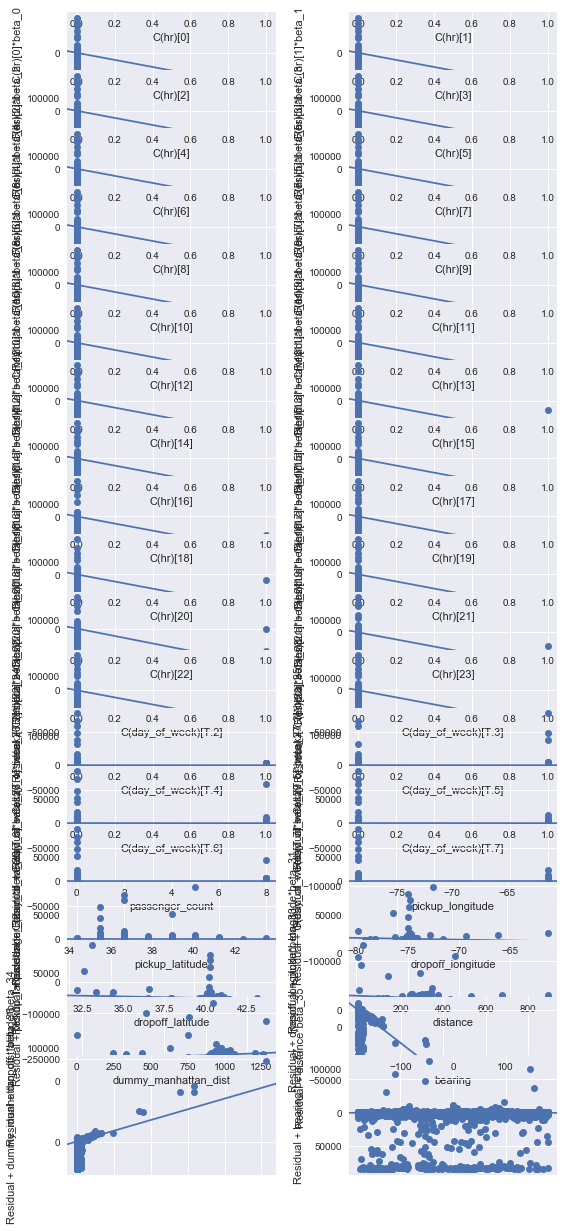

In [368]:
fig = plt.figure(figsize=(8, 15))
sm.graphics.plot_ccpr_grid(resultForLR1, fig=fig)
fig.suptitle("")
plt.show()

In [331]:
#model1 = sm.OLS.from_formula("trip_duration ~ C(vendor_id) + passenger_count + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + C(store_and_fwd_flag) + month +  hr +  day_of_week + distance + dummy_manhattan_dist + bearing", train)
model1_1 = sm.OLS.from_formula("trip_duration ~ passenger_count + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude +  C(hr) +  C(day_of_week) + distance + dummy_manhattan_dist + bearing", train)
resultForLR1_1 = model1_1.fit()
print (resultForLR1_1.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     1871.
Date:                Mon, 16 Oct 2017   Prob (F-statistic):               0.00
Time:                        11:39:46   Log-Likelihood:            -6.1340e+06
No. Observations:              701076   AIC:                         1.227e+07
Df Residuals:                  701038   BIC:                         1.227e+07
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             7.857e+04 

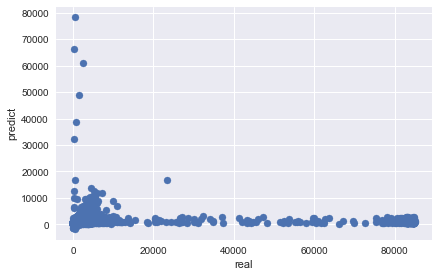

In [332]:
c1_1= 'passenger_count+pickup_longitude+pickup_latitude+dropoff_longitude+dropoff_latitude+hr+day_of_week+distance+dummy_manhattan_dist+bearing'.split('+')
m1_1Predict = resultForLR1_1.predict(train[c1_1])
plt.scatter(train['trip_duration'], m1_1Predict)
plt.xlabel(u'real')
plt.ylabel(u'predict')
plt.show()

In [361]:
sm.stats.anova_lm(resultForLR1_1, typ=2)

,sum_sq,df,F,PR(>F)
C(hr),5.830791e+09,23.0,108.855815,0.000000e+00
C(day_of_week),1.536523e+09,6.0,109.961315,3.452307e-139
passenger_count,2.022631e+08,1.0,86.849777,1.174078e-20
pickup_longitude,6.109563e+07,1.0,26.233860,3.025521e-07
pickup_latitude,1.581771e+08,1.0,67.919660,1.705833e-16
dropoff_longitude,3.095952e+08,1.0,132.937133,9.391941e-31
dropoff_latitude,5.728338e+08,1.0,245.969179,2.007553e-55
distance,1.032503e+10,1.0,4433.467190,0.000000e+00
dummy_manhattan_dist,3.944652e+09,1.0,1693.794432,0.000000e+00
bearing,1.693219e+07,1.0,7.270515,7.009736e-03


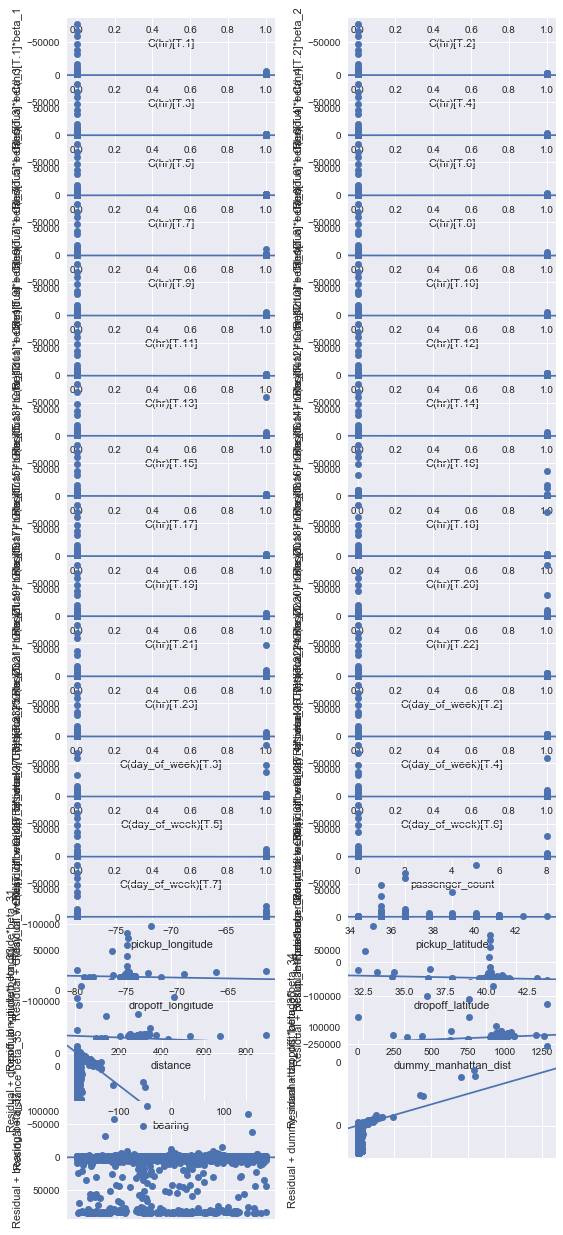

In [367]:
fig = plt.figure(figsize=(8, 15))
sm.graphics.plot_ccpr_grid(resultForLR1_1, fig=fig)
fig.suptitle("")
plt.show()

In [333]:
model2 = sm.OLS.from_formula("trip_duration ~ passenger_count + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude +  hr +  day_of_week + distance + dummy_manhattan_dist + bearing + 0", train)
resultForLR2 = model2.fit()
print (resultForLR2.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                 2.772e+04
Date:                Mon, 16 Oct 2017   Prob (F-statistic):               0.00
Time:                        11:39:57   Log-Likelihood:            -6.1356e+06
No. Observations:              701076   AIC:                         1.227e+07
Df Residuals:                  701066   BIC:                         1.227e+07
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
passenger_count         12.5082 

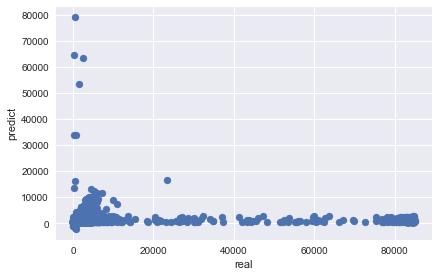

In [334]:
c2='passenger_count+pickup_longitude+pickup_latitude+dropoff_longitude+dropoff_latitude+hr+day_of_week+distance+dummy_manhattan_dist+bearing'.split('+')
m2Predict = resultForLR2.predict(train[c2])
plt.scatter(train['trip_duration'], m2Predict)
plt.xlabel(u'real')
plt.ylabel(u'predict')
plt.show()

In [360]:
sm.stats.anova_lm(resultForLR2, typ=2)

,sum_sq,df,F,PR(>F)
passenger_count,1.907074e+08,1.0,81.514514,1.744019e-19
pickup_longitude,5.614393e+06,1.0,2.399774,1.213532e-01
pickup_latitude,6.349213e+08,1.0,271.385958,5.812136e-61
dropoff_longitude,2.375571e+07,1.0,10.153963,1.439976e-03
dropoff_latitude,3.559826e+08,1.0,152.158500,5.899520e-35
hr,1.638634e+08,1.0,70.040531,5.820297e-17
day_of_week,2.974319e+08,1.0,127.132050,1.748354e-29
distance,9.829702e+09,1.0,4201.533676,0.000000e+00
dummy_manhattan_dist,3.549732e+09,1.0,1517.270667,0.000000e+00
bearing,7.816024e+06,1.0,3.340822,6.758125e-02


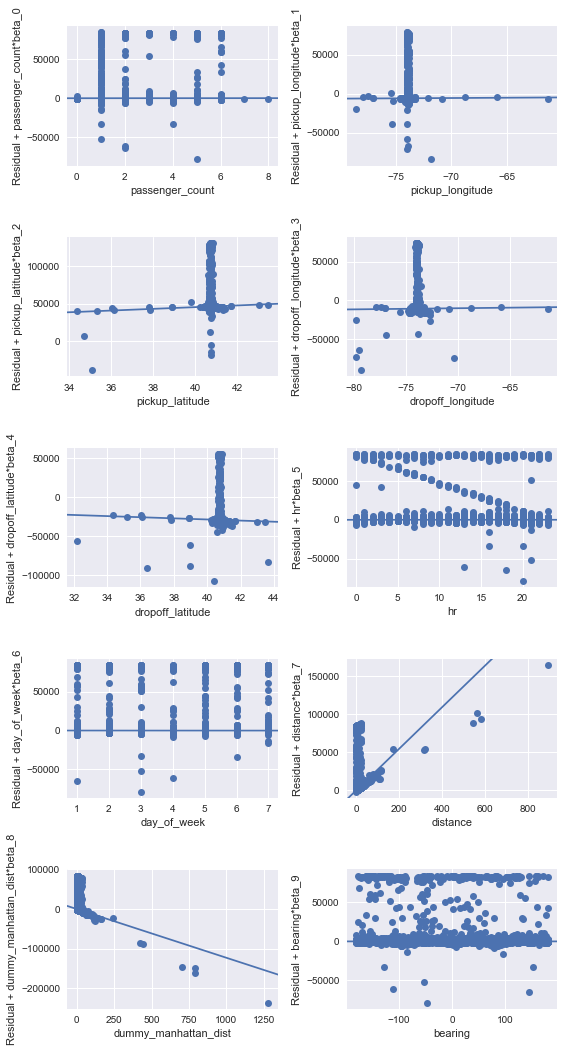

In [366]:
fig = plt.figure(figsize=(8, 15))
sm.graphics.plot_ccpr_grid(resultForLR2, fig=fig)
fig.suptitle("")
plt.show()

In [335]:
model2_1 = sm.OLS.from_formula("trip_duration ~ passenger_count + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude +  hr +  day_of_week + distance + dummy_manhattan_dist + bearing", train)
resultForLR2_1 = model2_1.fit()
print (resultForLR2_1.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     6598.
Date:                Mon, 16 Oct 2017   Prob (F-statistic):               0.00
Time:                        11:40:04   Log-Likelihood:            -6.1355e+06
No. Observations:              701076   AIC:                         1.227e+07
Df Residuals:                  701065   BIC:                         1.227e+07
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             7.408e+04 

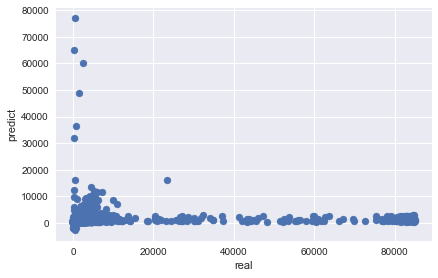

In [336]:
c2_1='passenger_count+pickup_longitude+pickup_latitude+dropoff_longitude+dropoff_latitude+hr+day_of_week+distance+dummy_manhattan_dist+bearing'.split('+')
m2_1Predict = resultForLR2_1.predict(train[c2_1])
plt.scatter(train['trip_duration'], m2_1Predict)
plt.xlabel(u'real')
plt.ylabel(u'predict')
plt.show()

In [359]:
sm.stats.anova_lm(resultForLR2_1, typ=2)

,sum_sq,df,F,PR(>F)
passenger_count,1.901080e+08,1.0,81.287244,1.956540e-19
pickup_longitude,1.442662e+08,1.0,61.686010,4.033969e-15
pickup_latitude,2.923785e+08,1.0,125.016554,5.075843e-29
dropoff_longitude,2.177004e+08,1.0,93.085331,5.024592e-22
dropoff_latitude,5.739898e+08,1.0,245.429224,2.632380e-55
hr,1.692847e+08,1.0,72.383523,1.775276e-17
day_of_week,2.946306e+08,1.0,125.979522,3.124636e-29
distance,9.614897e+09,1.0,4111.182112,0.000000e+00
dummy_manhattan_dist,3.571808e+09,1.0,1527.250297,0.000000e+00
bearing,1.730153e+06,1.0,0.739787,3.897295e-01


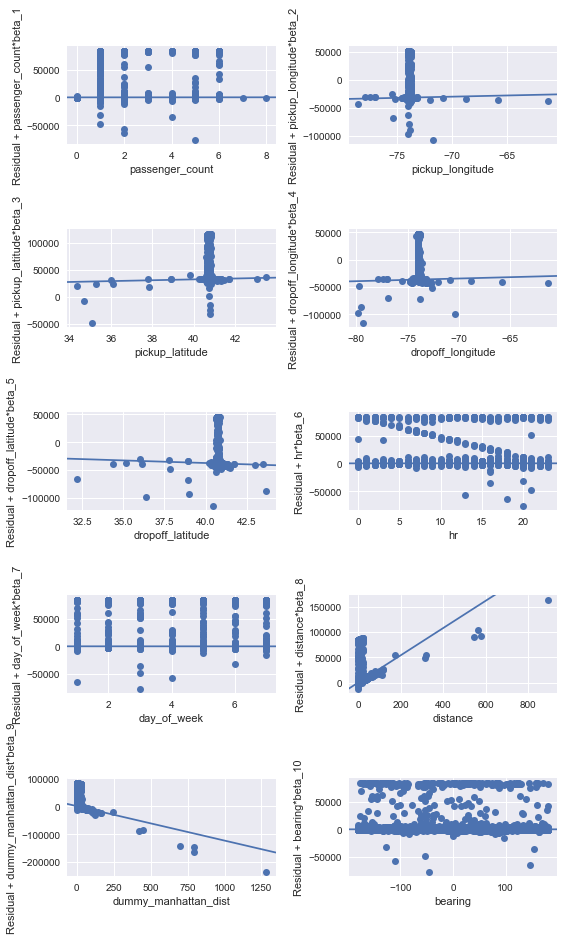

In [365]:
fig = plt.figure(figsize=(8, 15))
sm.graphics.plot_ccpr_grid(resultForLR2_1, fig=fig)
fig.suptitle("")
plt.show()

In [337]:
model3 = sm.OLS.from_formula("trip_duration ~ pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude +  hr +  day_of_week + distance + dummy_manhattan_dist + bearing + 0", train)
resultForLR3 = model3.fit()
print (resultForLR3.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                 3.079e+04
Date:                Mon, 16 Oct 2017   Prob (F-statistic):               0.00
Time:                        11:40:11   Log-Likelihood:            -6.1356e+06
No. Observations:              701076   AIC:                         1.227e+07
Df Residuals:                  701067   BIC:                         1.227e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
pickup_longitude        77.5816 

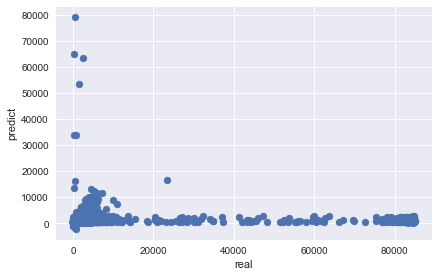

In [338]:
c3 = 'pickup_longitude+pickup_latitude+dropoff_longitude+dropoff_latitude+hr+day_of_week+distance+dummy_manhattan_dist+bearing'.split('+')
m3Predict = resultForLR3.predict(train[c3])
plt.scatter(train['trip_duration'], m3Predict)
plt.xlabel(u'real')
plt.ylabel(u'predict')
plt.show()

In [358]:
sm.stats.anova_lm(resultForLR3, typ=2)

,sum_sq,df,F,PR(>F)
pickup_longitude,5.631417e+06,1.0,2.406774,1.208116e-01
pickup_latitude,6.335466e+08,1.0,270.767301,7.927117e-61
dropoff_longitude,2.350985e+07,1.0,10.047719,1.525433e-03
dropoff_latitude,3.554488e+08,1.0,151.912917,6.675427e-35
hr,1.679119e+08,1.0,71.762733,2.431512e-17
day_of_week,2.853413e+08,1.0,121.950146,2.379910e-28
distance,9.829815e+09,1.0,4201.099655,0.000000e+00
dummy_manhattan_dist,3.548254e+09,1.0,1516.464761,0.000000e+00
bearing,7.777596e+06,1.0,3.324015,6.827533e-02
Residual,1.640370e+12,701067.0,NaN,NaN


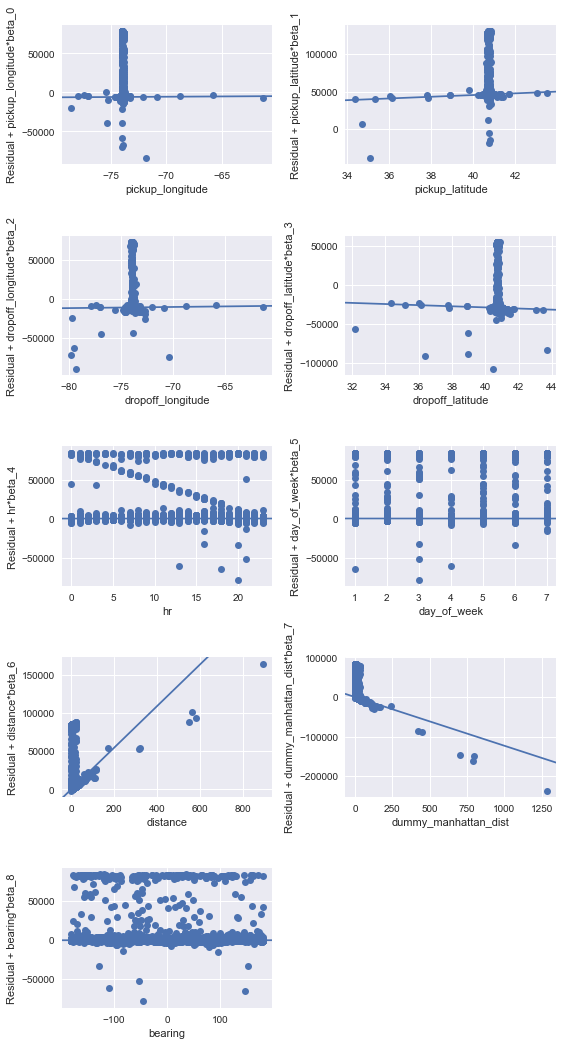

In [364]:
fig = plt.figure(figsize=(8, 15))
sm.graphics.plot_ccpr_grid(resultForLR3, fig=fig)
fig.suptitle("")
plt.show()

In [339]:
model3_1 = sm.OLS.from_formula("trip_duration ~ pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude +  hr +  day_of_week + distance + dummy_manhattan_dist + bearing", train)
resultForLR3_1 = model3_1.fit()
print (resultForLR3_1.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     7321.
Date:                Mon, 16 Oct 2017   Prob (F-statistic):               0.00
Time:                        11:40:18   Log-Likelihood:            -6.1355e+06
No. Observations:              701076   AIC:                         1.227e+07
Df Residuals:                  701066   BIC:                         1.227e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             7.412e+04 

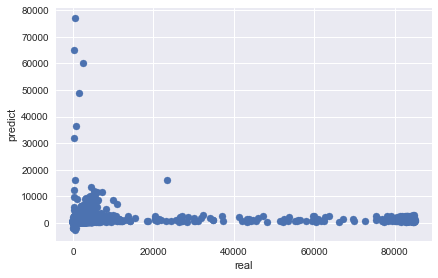

In [340]:
c3_1 = 'pickup_longitude+pickup_latitude+dropoff_longitude+dropoff_latitude+hr+day_of_week+distance+dummy_manhattan_dist+bearing'.split('+')
m3_1Predict = resultForLR3_1.predict(train[c3_1])
plt.scatter(train['trip_duration'], m3_1Predict)
plt.xlabel(u'real')
plt.ylabel(u'predict')
plt.show()

In [357]:
sm.stats.anova_lm(resultForLR3_1, typ=2)

,sum_sq,df,F,PR(>F)
pickup_longitude,1.444658e+08,1.0,61.764281,3.876775e-15
pickup_latitude,2.913647e+08,1.0,124.568798,6.360437e-29
dropoff_longitude,2.171832e+08,1.0,92.853586,5.648680e-22
dropoff_latitude,5.734684e+08,1.0,245.178204,2.985782e-55
hr,1.733957e+08,1.0,74.132861,7.317950e-18
day_of_week,2.826145e+08,1.0,120.827797,4.189952e-28
distance,9.614908e+09,1.0,4110.716158,0.000000e+00
dummy_manhattan_dist,3.570339e+09,1.0,1526.447430,0.000000e+00
bearing,1.710187e+06,1.0,0.731166,3.925058e-01
Residual,1.639784e+12,701066.0,NaN,NaN


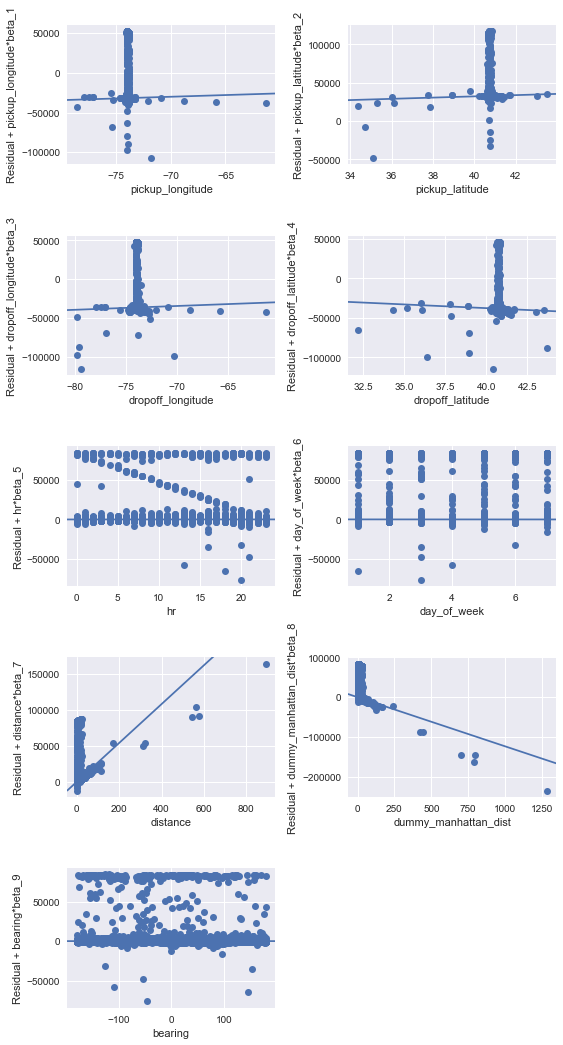

In [363]:
fig = plt.figure(figsize=(8, 15))
sm.graphics.plot_ccpr_grid(resultForLR3_1, fig=fig)
fig.suptitle("")
plt.show()

In [341]:
model4 = sm.OLS.from_formula("trip_duration ~ pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude +  C(hr) +  C(day_of_week) + distance + dummy_manhattan_dist + bearing + 0", train)
resultForLR4 = model4.fit()
print (resultForLR4.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     1921.
Date:                Mon, 16 Oct 2017   Prob (F-statistic):               0.00
Time:                        11:40:35   Log-Likelihood:            -6.1340e+06
No. Observations:              701076   AIC:                         1.227e+07
Df Residuals:                  701039   BIC:                         1.227e+07
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
C(hr)[0]               7.86e+04 

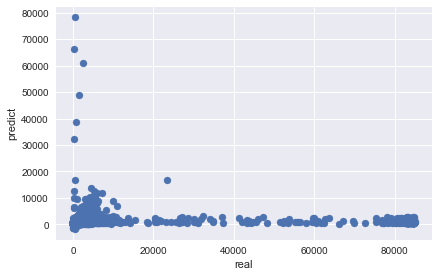

In [342]:
c4 = 'pickup_longitude+pickup_latitude+dropoff_longitude+dropoff_latitude+hr+day_of_week+distance+dummy_manhattan_dist+bearing'.split('+')
m4Predict = resultForLR4.predict(train[c4])
plt.scatter(train['trip_duration'], m4Predict)
plt.xlabel(u'real')
plt.ylabel(u'predict')
plt.show()

In [355]:
sm.stats.anova_lm(resultForLR4, typ=2)

,sum_sq,df,F,PR(>F)
C(hr),6.431589e+09,24.0,115.055108,0.000000e+00
C(day_of_week),1.518256e+09,6.0,108.640722,1.764521e-137
pickup_longitude,6.145716e+07,1.0,26.385866,2.796534e-07
pickup_latitude,1.579080e+08,1.0,67.795812,1.816404e-16
dropoff_longitude,3.088236e+08,1.0,132.589542,1.118870e-30
dropoff_latitude,5.723565e+08,1.0,245.734122,2.258900e-55
distance,1.032252e+10,1.0,4431.847024,0.000000e+00
dummy_manhattan_dist,3.941580e+09,1.0,1692.268160,0.000000e+00
bearing,1.679459e+07,1.0,7.210547,7.247811e-03
Residual,1.632839e+12,701039.0,NaN,NaN


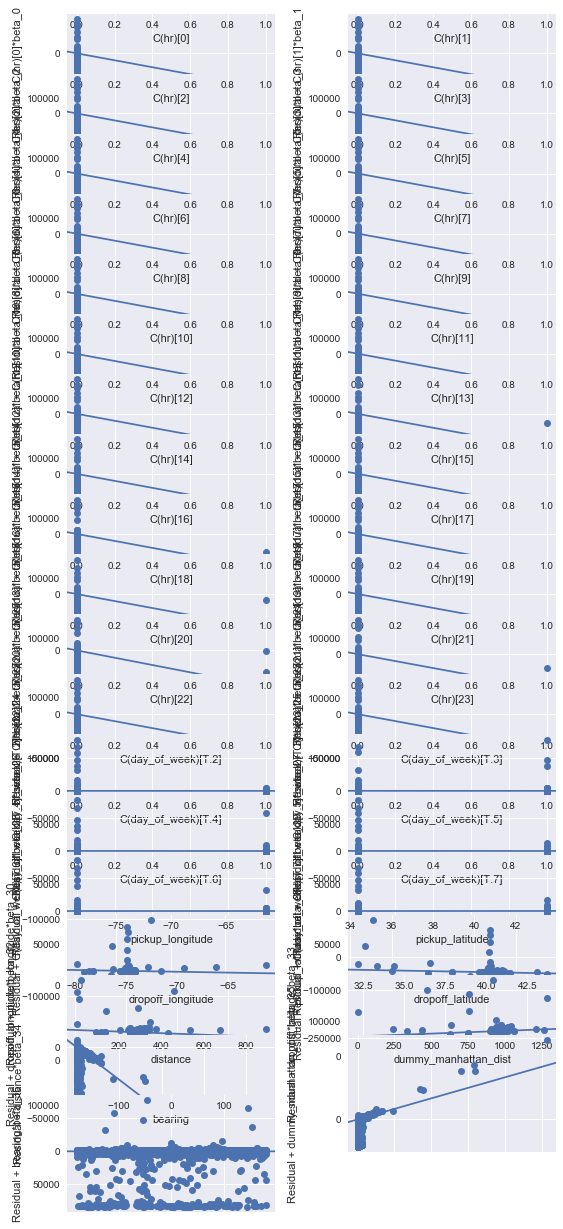

In [356]:
fig = plt.figure(figsize=(8, 15))
sm.graphics.plot_ccpr_grid(resultForLR4, fig=fig)
fig.suptitle("")
plt.show()

In [343]:
model4_1 = sm.OLS.from_formula("trip_duration ~ pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude +  C(hr) +  C(day_of_week) + distance + dummy_manhattan_dist + bearing", train)
resultForLR4_1 = model4_1.fit()
print (resultForLR4_1.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     1921.
Date:                Mon, 16 Oct 2017   Prob (F-statistic):               0.00
Time:                        11:40:53   Log-Likelihood:            -6.1340e+06
No. Observations:              701076   AIC:                         1.227e+07
Df Residuals:                  701039   BIC:                         1.227e+07
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              7.86e+04 

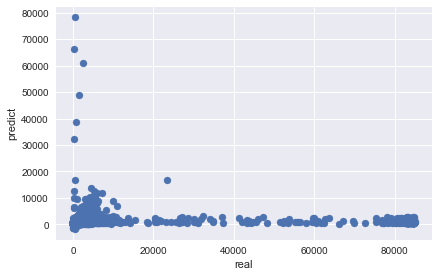

In [344]:
c4_1 = 'pickup_longitude+pickup_latitude+dropoff_longitude+dropoff_latitude+hr+day_of_week+distance+dummy_manhattan_dist+bearing'.split('+')
m4_1Predict = resultForLR4_1.predict(train[c4_1])
plt.scatter(train['trip_duration'], m4_1Predict)
plt.xlabel(u'real')
plt.ylabel(u'predict')
plt.show()

In [353]:
sm.stats.anova_lm(resultForLR4_1, typ=2)

,sum_sq,df,F,PR(>F)
C(hr),5.833890e+09,23.0,108.900335,0.000000e+00
C(day_of_week),1.518256e+09,6.0,108.640722,1.764521e-137
pickup_longitude,6.145716e+07,1.0,26.385866,2.796534e-07
pickup_latitude,1.579080e+08,1.0,67.795812,1.816404e-16
dropoff_longitude,3.088236e+08,1.0,132.589542,1.118870e-30
dropoff_latitude,5.723565e+08,1.0,245.734122,2.258900e-55
distance,1.032252e+10,1.0,4431.847024,0.000000e+00
dummy_manhattan_dist,3.941580e+09,1.0,1692.268160,0.000000e+00
bearing,1.679459e+07,1.0,7.210547,7.247811e-03
Residual,1.632839e+12,701039.0,NaN,NaN


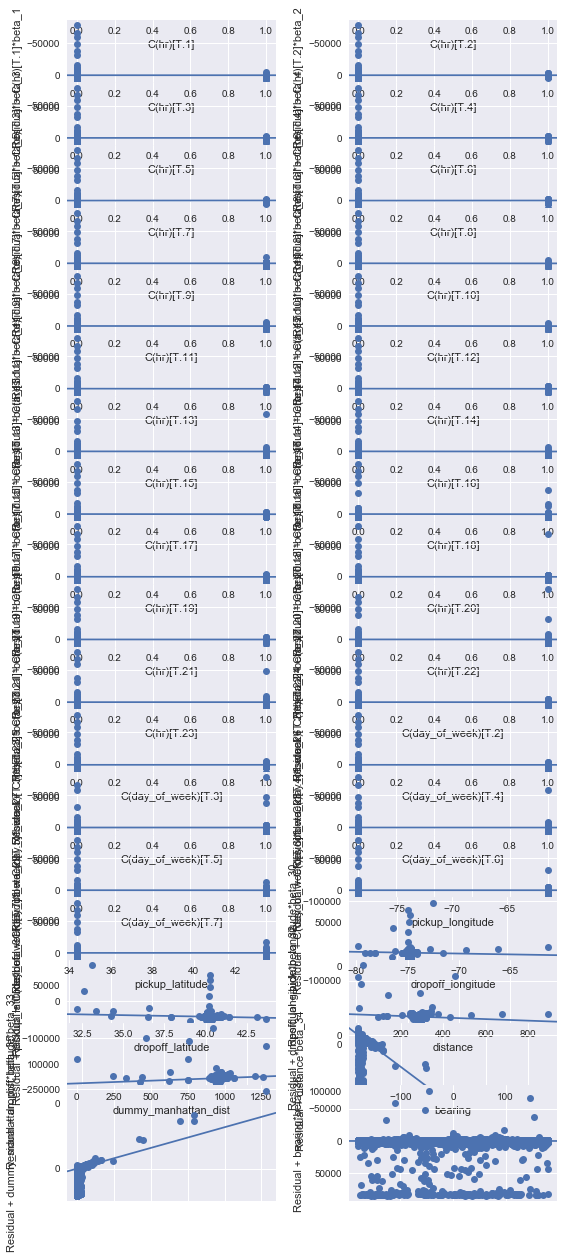

In [354]:
fig = plt.figure(figsize=(8, 15))
sm.graphics.plot_ccpr_grid(resultForLR4_1, fig=fig)
fig.suptitle("")
plt.show()

In [345]:
#model1 = sm.OLS.from_formula("trip_duration ~ C(vendor_id) + passenger_count + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + C(store_and_fwd_flag) + month +  hr +  day_of_week + distance + dummy_manhattan_dist + bearing", train)
model5 = sm.OLS.from_formula("trip_duration ~ passenger_count + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude +  hr +  C(day_of_week) + distance + dummy_manhattan_dist + bearing + 0", train)
resultForLR5 = model5.fit()
print (resultForLR5.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     4437.
Date:                Mon, 16 Oct 2017   Prob (F-statistic):               0.00
Time:                        11:41:08   Log-Likelihood:            -6.1352e+06
No. Observations:              701076   AIC:                         1.227e+07
Df Residuals:                  701060   BIC:                         1.227e+07
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
C(day_of_week)[1]     7.505e+04 

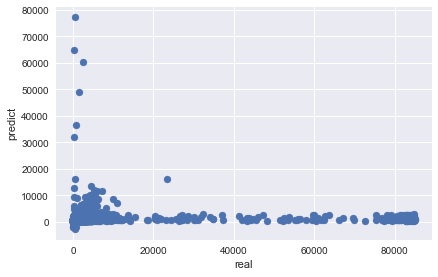

In [346]:
c5= 'passenger_count+pickup_longitude+pickup_latitude+dropoff_longitude+dropoff_latitude+hr+day_of_week+distance+dummy_manhattan_dist+bearing'.split('+')
m5Predict = resultForLR5.predict(train[c5])
plt.scatter(train['trip_duration'], m5Predict)
plt.xlabel(u'real')
plt.ylabel(u'predict')
plt.show()

In [351]:
sm.stats.anova_lm(resultForLR5, typ=2)

,sum_sq,df,F,PR(>F)
C(day_of_week),2.128631e+09,7.0,130.122138,2.911978e-192
passenger_count,2.016384e+08,1.0,86.282372,1.564171e-20
pickup_longitude,1.515501e+08,1.0,64.849268,8.097717e-16
pickup_latitude,2.798692e+08,1.0,119.757841,7.184680e-28
dropoff_longitude,2.137891e+08,1.0,91.481741,1.129705e-21
dropoff_latitude,5.699862e+08,1.0,243.900819,5.668485e-55
hr,1.189974e+08,1.0,50.919749,9.631305e-13
distance,9.637776e+09,1.0,4124.067223,0.000000e+00
dummy_manhattan_dist,3.581760e+09,1.0,1532.658341,0.000000e+00
bearing,1.959092e+06,1.0,0.838308,3.598814e-01


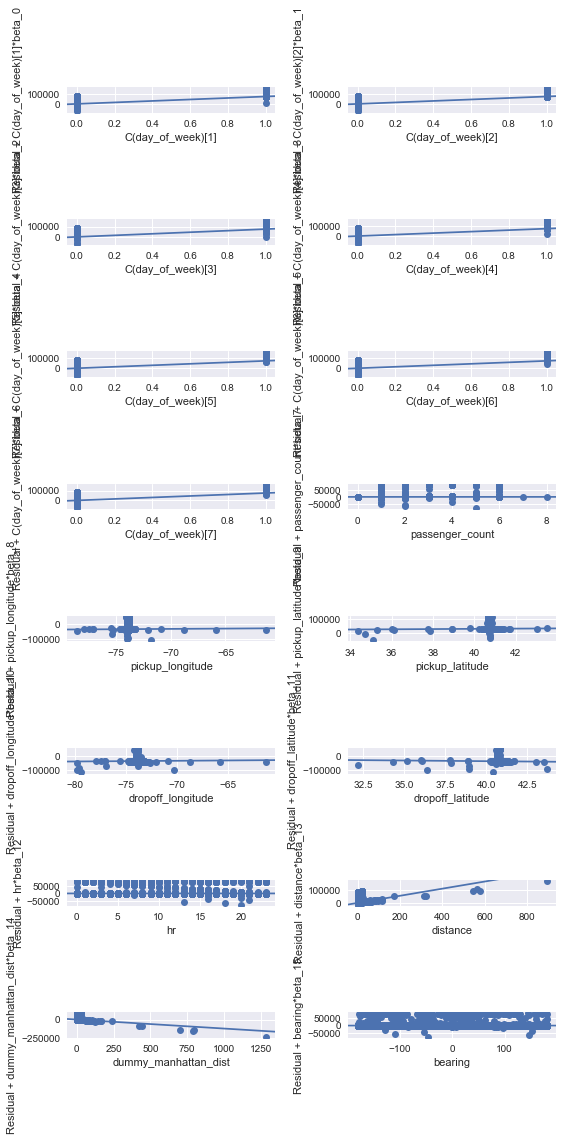

In [352]:
fig = plt.figure(figsize=(8, 15))
sm.graphics.plot_ccpr_grid(resultForLR5, fig=fig)
fig.suptitle("")
plt.show()

In [377]:
#model1 = sm.OLS.from_formula("trip_duration ~ C(vendor_id) + passenger_count + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + C(store_and_fwd_flag) + month +  hr +  day_of_week + distance + dummy_manhattan_dist + bearing", train)
model6 = sm.OLS.from_formula("trip_duration ~ passenger_count + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude +  C(hr) +  day_of_week + distance + dummy_manhattan_dist + bearing + 0", train)
resultForLR6 = model6.fit()
print (resultForLR6.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     2144.
Date:                Mon, 16 Oct 2017   Prob (F-statistic):               0.00
Time:                        12:11:19   Log-Likelihood:            -6.1343e+06
No. Observations:              701076   AIC:                         1.227e+07
Df Residuals:                  701043   BIC:                         1.227e+07
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
C(hr)[0]              7.762e+04 

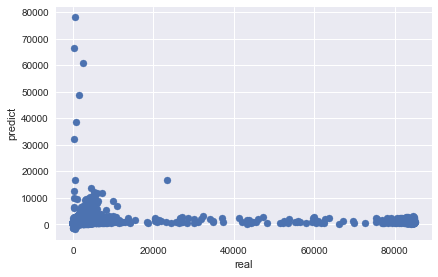

In [378]:
c6= 'passenger_count+pickup_longitude+pickup_latitude+dropoff_longitude+dropoff_latitude+hr+day_of_week+distance+dummy_manhattan_dist+bearing'.split('+')
m6Predict = resultForLR6.predict(train[c6])
plt.scatter(train['trip_duration'], m6Predict)
plt.xlabel(u'real')
plt.ylabel(u'predict')
plt.show()

In [379]:
sm.stats.anova_lm(resultForLR6, typ=2)

,sum_sq,df,F,PR(>F)
C(hr),6.362853e+09,24.0,113.746586,0.000000e+00
passenger_count,1.922427e+08,1.0,82.479802,1.070210e-19
pickup_longitude,5.423332e+07,1.0,23.268262,1.409356e-06
pickup_latitude,1.640696e+08,1.0,70.392421,4.869471e-17
dropoff_longitude,3.172786e+08,1.0,136.125189,1.885990e-31
dropoff_latitude,5.759086e+08,1.0,247.087790,1.145175e-55
day_of_week,1.925205e+08,1.0,82.598978,1.007598e-19
distance,1.031533e+10,1.0,4425.688956,0.000000e+00
dummy_manhattan_dist,3.942510e+09,1.0,1691.494250,0.000000e+00
bearing,1.674222e+07,1.0,7.183080,7.359598e-03


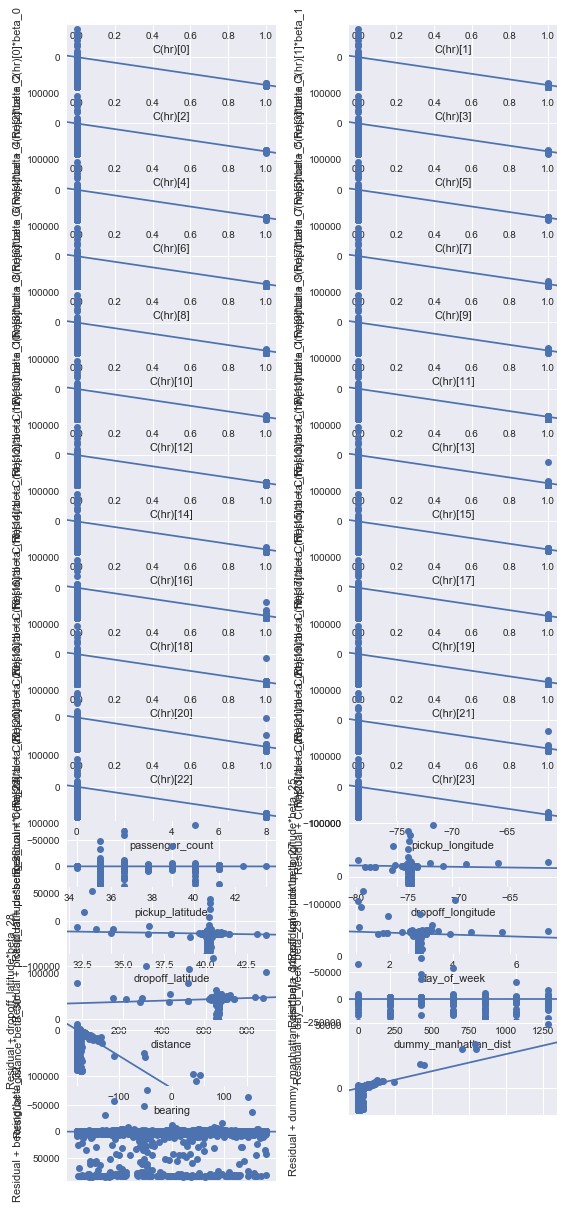

In [380]:
fig = plt.figure(figsize=(8, 15))
sm.graphics.plot_ccpr_grid(resultForLR6, fig=fig)
fig.suptitle("")
plt.show()

In [381]:
model7 = sm.OLS.from_formula("trip_duration ~ passenger_count + C(hr) +  day_of_week + distance + dummy_manhattan_dist + bearing + 0", train)
resultForLR7 = model7.fit()
print (resultForLR7.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     2430.
Date:                Mon, 16 Oct 2017   Prob (F-statistic):               0.00
Time:                        12:12:27   Log-Likelihood:            -6.1345e+06
No. Observations:              701076   AIC:                         1.227e+07
Df Residuals:                  701047   BIC:                         1.227e+07
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
C(hr)[0]               349.1711 

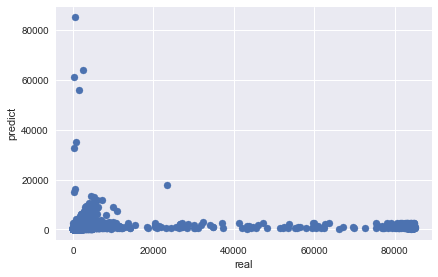

In [382]:
c7= 'passenger_count+hr+day_of_week+distance+dummy_manhattan_dist+bearing'.split('+')
m7Predict = resultForLR7.predict(train[c7])
plt.scatter(train['trip_duration'], m7Predict)
plt.xlabel(u'real')
plt.ylabel(u'predict')
plt.show()

In [383]:
sm.stats.anova_lm(resultForLR7, typ=2)

,sum_sq,df,F,PR(>F)
C(hr),2.742113e+10,24.0,489.832622,0.000000e+00
passenger_count,1.912762e+08,1.0,82.003904,1.361521e-19
day_of_week,1.982206e+08,1.0,84.981101,3.020255e-20
distance,1.149183e+10,1.0,4926.776558,0.000000e+00
dummy_manhattan_dist,4.532329e+09,1.0,1943.099525,0.000000e+00
bearing,2.890252e+07,1.0,12.391085,4.314159e-04
Residual,1.635210e+12,701047.0,NaN,NaN


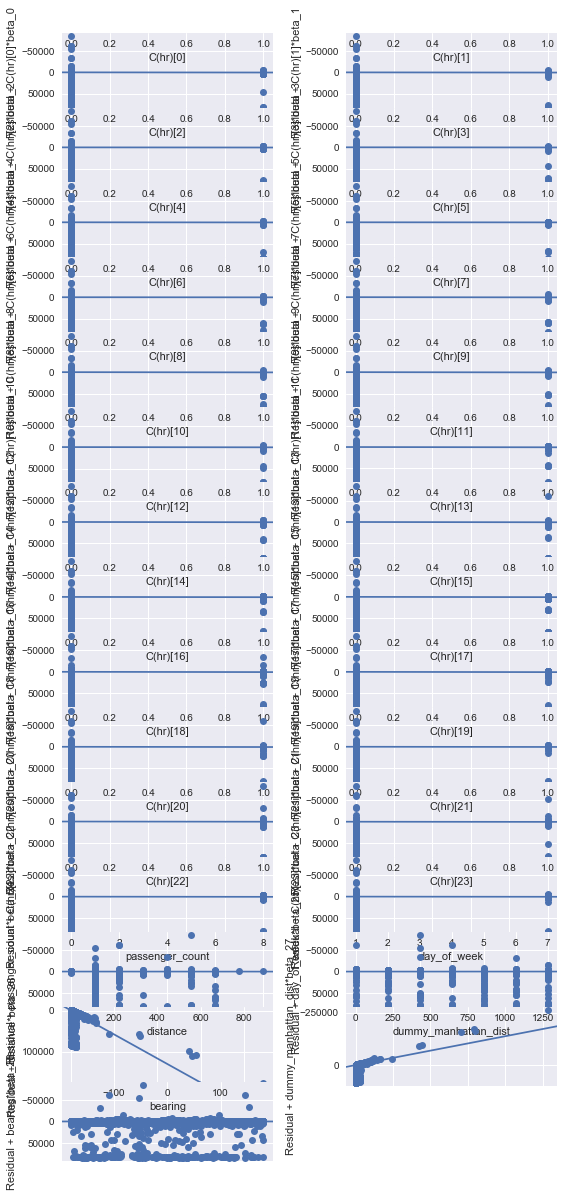

In [384]:
fig = plt.figure(figsize=(8, 15))
sm.graphics.plot_ccpr_grid(resultForLR7, fig=fig)
fig.suptitle("")
plt.show()

In [386]:
model8 = sm.OLS.from_formula("trip_duration ~ passenger_count + hr + C(day_of_week) + distance + dummy_manhattan_dist + bearing + 0", train)
resultForLR8 = model8.fit()
print (resultForLR8.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     5997.
Date:                Mon, 16 Oct 2017   Prob (F-statistic):               0.00
Time:                        12:14:00   Log-Likelihood:            -6.1355e+06
No. Observations:              701076   AIC:                         1.227e+07
Df Residuals:                  701064   BIC:                         1.227e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
C(day_of_week)[1]      375.3595 

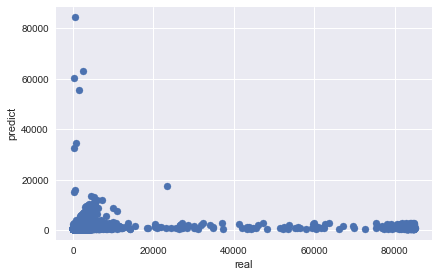

In [387]:
c8= 'passenger_count+hr+day_of_week+distance+dummy_manhattan_dist+bearing'.split('+')
m8Predict = resultForLR8.predict(train[c8])
plt.scatter(train['trip_duration'], m8Predict)
plt.xlabel(u'real')
plt.ylabel(u'predict')
plt.show()

In [388]:
sm.stats.anova_lm(resultForLR8, typ=2)

,sum_sq,df,F,PR(>F)
C(day_of_week),1.581343e+10,7.0,965.926660,0.000000e+00
passenger_count,2.003270e+08,1.0,85.655550,2.147476e-20
hr,1.086969e+08,1.0,46.476463,9.280006e-12
distance,1.080589e+10,1.0,4620.369268,0.000000e+00
dummy_manhattan_dist,4.160621e+09,1.0,1778.992535,0.000000e+00
bearing,3.288262e+05,1.0,0.140599,7.076863e-01
Residual,1.639614e+12,701064.0,NaN,NaN


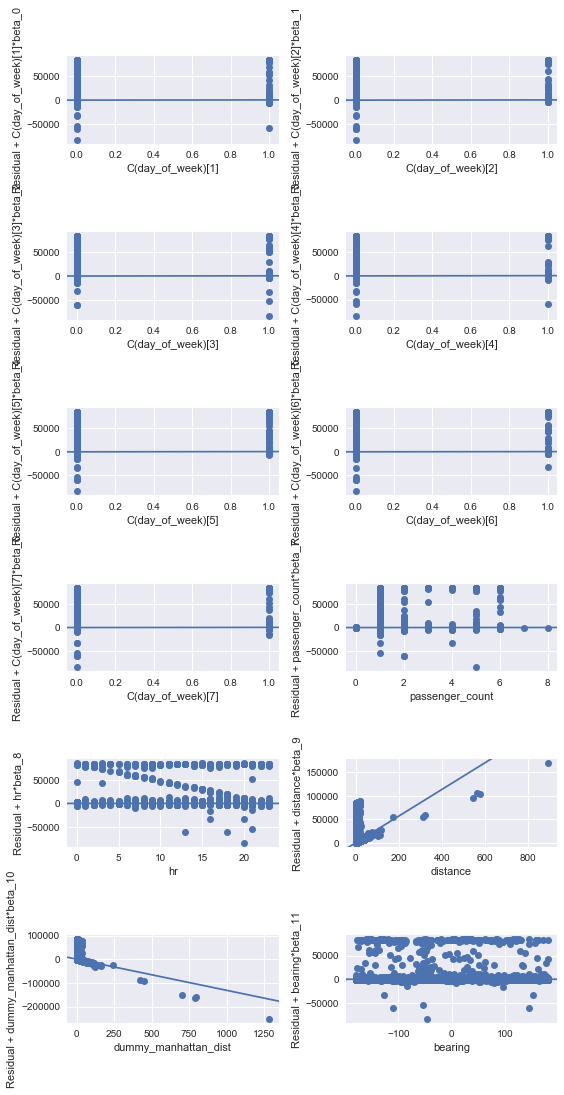

In [389]:
fig = plt.figure(figsize=(8, 15))
sm.graphics.plot_ccpr_grid(resultForLR8, fig=fig)
fig.suptitle("")
plt.show()

In [390]:
model9 = sm.OLS.from_formula("trip_duration ~ passenger_count +minute +hr +  C(day_of_week) + distance + dummy_manhattan_dist + bearing + 0", train)
resultForLR9 = model9.fit()
print (resultForLR9.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     5498.
Date:                Mon, 16 Oct 2017   Prob (F-statistic):               0.00
Time:                        12:16:34   Log-Likelihood:            -6.1355e+06
No. Observations:              701076   AIC:                         1.227e+07
Df Residuals:                  701063   BIC:                         1.227e+07
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
C(day_of_week)[1]      383.1323 

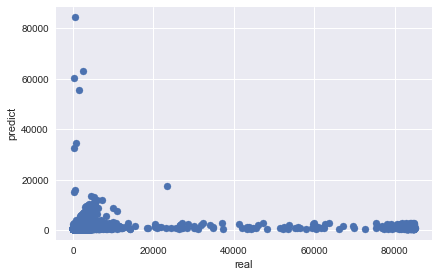

In [392]:
c9= 'passenger_count+minute+hr+day_of_week+distance+dummy_manhattan_dist+bearing'.split('+')
m9Predict = resultForLR9.predict(train[c9])
plt.scatter(train['trip_duration'], m9Predict)
plt.xlabel(u'real')
plt.ylabel(u'predict')
plt.show()

In [393]:
sm.stats.anova_lm(resultForLR9, typ=2)

,sum_sq,df,F,PR(>F)
C(day_of_week),1.230711e+10,7.0,751.756757,0.000000e+00
passenger_count,2.004595e+08,1.0,85.712806,2.086195e-20
minute,1.426930e+07,1.0,6.101292,1.350854e-02
hr,1.083735e+08,1.0,46.338524,9.956797e-12
distance,1.080237e+10,1.0,4618.898192,0.000000e+00
dummy_manhattan_dist,4.158845e+09,1.0,1778.246152,0.000000e+00
bearing,3.323543e+05,1.0,0.142109,7.061938e-01
Residual,1.639600e+12,701063.0,NaN,NaN


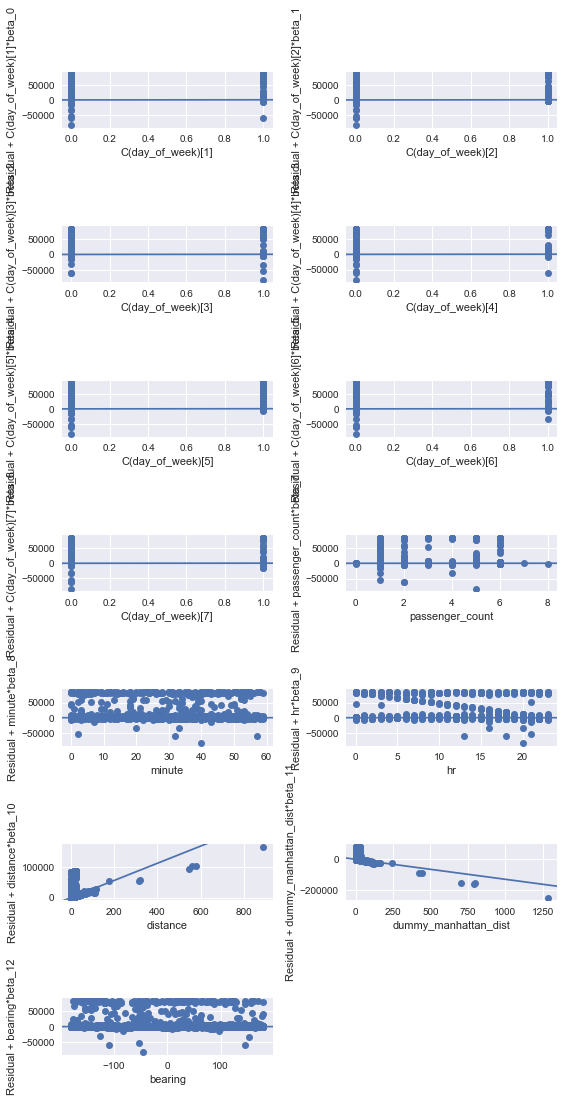

In [394]:
fig = plt.figure(figsize=(8, 15))
sm.graphics.plot_ccpr_grid(resultForLR9, fig=fig)
fig.suptitle("")
plt.show()